In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [31]:
#df = pd.read_csv('/host/data/data_exploration_output_1000lines.csv')
#df = pd.read_csv('data_exploration_filtered_lat.csv')

df = pd.read_csv('../auth_filtered_all_with_labels_sorted_2_with_labels_filtered.csv')

#cols = ["time","p(src_user)","p(dest_user)","p(src_nt_host)","p(dest_nt_host)","p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)"]
#cols = ["p(src_user)","p(dest_user)","p(src_nt_host)","p(dest_nt_host)","p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)", "is_malicious"]
cols = ["p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)", "is_malicious"]

#df = df[cols]

print("DF Shape: " + str(df.shape))

DF Shape: (10000704, 22)


In [32]:
#find secs between logins for src_nt_host
df = df.sort_values(['src_nt_host', 'time'], ascending=[True, True])

df['secs_since_last_login_by_src_nt_host'] = df.groupby(['src_nt_host'], sort=False)['time'].diff()

df['secs_since_last_login_by_src_nt_host'].fillna(0, inplace=True)

#find secs between logins for src_user
df = df.sort_values(['src_user', 'time'], ascending=[True, True])

df['secs_since_last_login_by_src_user'] = df.groupby(['src_user'], sort=False)['time'].diff()

df['secs_since_last_login_by_src_user'].fillna(0, inplace=True)

In [9]:
""" Function to bin time to a given hour """
import math

bins = [ i for i in range(1,math.ceil(df['time'].max() / 3600) + 1)]


def bin_time(time):
    return bins[math.ceil(time / 3600) - 1]

In [34]:
#Let's bin time and convert the seconds to a given hr 
df['bin_timed'] = df['time'].apply(bin_time)

In [35]:
#Let's find the distinct number of dest hosts for a src_host in a given hour
df['num_distinct_dest_nt_host_per_src_nt_host_per_hour'] = \
    df.groupby(['bin_timed','src_nt_host'])['dest_nt_host'].transform('nunique')

#Let's find the distinct number of dest_users for a src_host in a given hour
df['num_distinct_dest_user_per_src_nt_host_per_hour'] = \
    df.groupby(['bin_timed','src_nt_host'])['dest_user'].transform('nunique')
  
#Let's find the distinct number of dest_users per a src_user in a given hour
df['num_distinct_dest_user_per_src_user_per_hour'] = \
    df.groupby(['bin_timed','src_user'])['dest_user'].transform('nunique')

In [36]:
#Let's make sure it's working as expected. 

df[(df['src_nt_host'] == 'C1065') & (df['bin_timed'] == 1)]['dest_nt_host'].value_counts()

C1065    3037
C586       77
C625       20
C529       15
Name: dest_nt_host, dtype: int64

In [37]:
cols = ["p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)", "secs_since_last_login_by_src_nt_host", "num_distinct_dest_nt_host_per_src_nt_host_per_hour", "num_distinct_dest_user_per_src_nt_host_per_hour", "num_distinct_dest_user_per_src_user_per_hour", "is_malicious"]

df = df[cols]

In [15]:
#scaler = StandardScaler()

scaler = RobustScaler()

In [41]:
#df[["p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)"]] = scaler.fit_transform(df.as_matrix(["p(src_user n dest_user)","p(src_nt_host n dest_nt_host)","p(dest_user n dest_nt_host)","p(src_nt_host|dest_nt_host)","p(dest_user|src_user)","p(dest_nt_host|dest_user)"]))

df[["p(src_user n dest_user)",
    "p(src_nt_host n dest_nt_host)",
    "p(dest_user n dest_nt_host)",
    "p(src_nt_host|dest_nt_host)",
    "p(dest_user|src_user)",
    "p(dest_nt_host|dest_user)", 
    "secs_since_last_login_by_src_nt_host", 
    "num_distinct_dest_nt_host_per_src_nt_host_per_hour", 
    "num_distinct_dest_user_per_src_nt_host_per_hour", 
    "num_distinct_dest_user_per_src_user_per_hour"
           ]] = scaler.fit_transform(df.as_matrix(["p(src_user n dest_user)",
                                                    "p(src_nt_host n dest_nt_host)",
                                                    "p(dest_user n dest_nt_host)",
                                                    "p(src_nt_host|dest_nt_host)",
                                                    "p(dest_user|src_user)",
                                                    "p(dest_nt_host|dest_user)", 
                                                    "secs_since_last_login_by_src_nt_host", 
                                                    "num_distinct_dest_nt_host_per_src_nt_host_per_hour", 
                                                    "num_distinct_dest_user_per_src_nt_host_per_hour", 
                                                    "num_distinct_dest_user_per_src_user_per_hour"]))

In [42]:
df.head(1)

,p(src_user n dest_user),p(src_nt_host n dest_nt_host),p(dest_user n dest_nt_host),p(src_nt_host|dest_nt_host),p(dest_user|src_user),p(dest_nt_host|dest_user),secs_since_last_login_by_src_nt_host,num_distinct_dest_nt_host_per_src_nt_host_per_hour,num_distinct_dest_user_per_src_nt_host_per_hour,num_distinct_dest_user_per_src_user_per_hour,is_malicious
1511269,17.712893,0.0,29.374846,0.0,4.19486,0.0,1.0,-1.0,-0.667054,0.0,0


In [43]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model, load_model
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
TEST_RATIO = 0.25
#df.sort_values('time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
#train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_x = df.iloc[:TRA_INDEX, 0:-1].values
#train_x = df.iloc[:TRA_INDEX, :].values
train_y = df.iloc[:TRA_INDEX, -1].values
#train_y = df.iloc[:TRA_INDEX, :].values

#test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_x = df.iloc[TRA_INDEX:, 0:-1].values
#test_x = df.iloc[TRA_INDEX:, :].values
test_y = df.iloc[TRA_INDEX:, -1].values
#test_y = df.iloc[TRA_INDEX:, :].values

In [45]:
# this is the size of our encoded representations
#encoding_dim = 3
input_dim = test_x.shape[1]

# this is our input placeholder
input_ph = Input(shape=(input_dim,))

# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_ph)
encoder = Dense(input_dim, activation='tanh',
                activity_regularizer=regularizers.l1(10e-5))(input_ph)

#encoder = Dense(int(input_dim / 2), activation='relu')(encoder)

encoder = Dense(input_dim - 1, activation='relu')(encoder)

encoder = Dense(input_dim - 2, activation='relu')(encoder)

encoder = Dense(input_dim - 3, activation='relu')(encoder)

#decoder = Dense(int(input_dim / 2), activation='tanh')(encoder)

decoder = Dense(input_dim - 3, activation='tanh')(encoder)

decoder = Dense(input_dim - 2, activation='tanh')(encoder)

decoder = Dense(input_dim - 1, activation='tanh')(encoder)

decoder = Dense(input_dim, activation='sigmoid')(decoder)


# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_ph, outputs=decoder)

In [46]:
# this model maps an input to its encoded representation
#encoder = Model(input_ph, encoded)

In [47]:
# create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

In [48]:
"""autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=1,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)"""

""" This section is built to compile the model and set up any checkpoints """

#nb_epoch = 250     ### Number of iterations run.
nb_epoch = 25
batch_size = 512  ### Size of sample to be used each time data loaded

autoencoder.compile(optimizer='adam',              #Optimizer
                    loss='binary_crossentropy',     # Loss Metric
                    metrics=['accuracy'])          #Accuracy

#save the best performing model to a file...
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

#training progress will be exported in a format that TensorBoard understands
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
# Fitting the model
history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),  #Remember our validation set is an identical copy!!!
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

###### BELOW:
# 1. We want to minimize the loss function, while improving our accuracy 
# 2. Loss function is calculated by the optimizer which is taking the derivative (dJ/dx + dJ/dy + dJ/dz) over and over to solve for
# the closest vale that minimizes loss. 

Train on 7500528 samples, validate on 2500176 samples
Epoch 1/25
7500528/7500528 [==============================] - 43s 6us/step - loss: -73.2581 - acc: 0.3698 - val_loss: -52.2532 - val_acc: 0.2895
Epoch 2/25
7500528/7500528 [==============================] - 42s 6us/step - loss: -82.5979 - acc: 0.3867 - val_loss: -52.3647 - val_acc: 0.2972
Epoch 3/25
7500528/7500528 [==============================] - 42s 6us/step - loss: -82.8454 - acc: 0.3962 - val_loss: -52.5999 - val_acc: 0.3079
Epoch 4/25
7500528/7500528 [==============================] - 43s 6us/step - loss: -82.8987 - acc: 0.4012 - val_loss: -52.6283 - val_acc: 0.3065
Epoch 5/25
7500528/7500528 [==============================] - 43s 6us/step - loss: -83.0845 - acc: 0.4026 - val_loss: -52.5728 - val_acc: 0.3103
Epoch 6/25
7500528/7500528 [==============================] - 44s 6us/step - loss: -83.0895 - acc: 0.4029 - val_loss: -52.7257 - val_acc: 0.3115
Epoch 7/25
7500528/7500528 [==============================] - 44s 6us/step -

In [38]:
"""history = autoencoder.fit(train_x, train_x,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(test_x, test_x),
                callbacks=[checkpointer, tensorboard]).history"""

'history = autoencoder.fit(train_x, train_x,\n                epochs=10,\n                batch_size=256,\n                shuffle=True,\n                validation_data=(test_x, test_x),\n                callbacks=[checkpointer, tensorboard]).history'

In [49]:
autoencoder = load_model('model.h5')

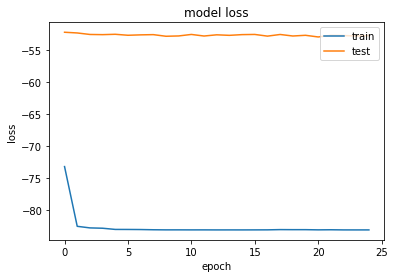

In [50]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()
plt.savefig('myfig')

In [51]:
### This is the function that "fits" our test data to the model. The output is our predictions. 

predictions = autoencoder.predict(test_x)

In [52]:
#predictions
#preds = predictions.reshape(56, 56)

In [53]:
### Very simple error squared. Probaly not appropriate for our complex problem, but using in this example...
mse = (predictions - test_x)**2

In [54]:
s = np.array(mse) # needs to be in an array format 

In [55]:
predictions[1]

array([  1.00000000e+00,   2.28330301e-14,   1.00000000e+00,
         1.25312968e-13,   1.00000000e+00,   2.51502734e-14,
         2.99863126e-02,   6.58161581e-01,   3.80682081e-01,
         1.17312937e-09], dtype=float32)

In [56]:
mse[1]

array([  6.44736380e+00,   5.21347263e-28,   1.46239318e+02,
         1.57033400e-26,   7.21212249e-01,   6.32536251e-28,
         8.99178944e-04,   8.43429528e-03,   7.41311112e-03,
         1.37623252e-18])

No handles with labels found to put in legend.


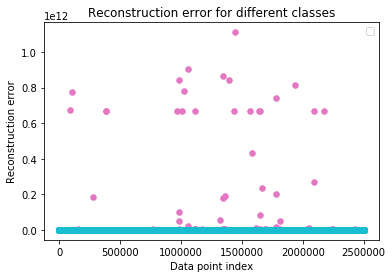

In [57]:
fig, ax = plt.subplots()

ax.plot(s, marker='o', ms=5.5, linestyle='')
        #label = "Anomaly" if i >= threshold else "normal") ### Need to fix this
            
#ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [58]:
# Redteam predictions

predictions_redteam = autoencoder.predict(test_x[test_y == 1])
predictions_nonredteam = autoencoder.predict(test_x[test_y == 0])

mse_rt = (predictions_redteam - test_x[test_y == 1])**2
mse_nrt = (predictions_nonredteam - test_x[test_y == 0])**2

s_rt = np.array(mse_rt) # needs to be in an array format 
s_nrt = np.array(mse_nrt)

No handles with labels found to put in legend.


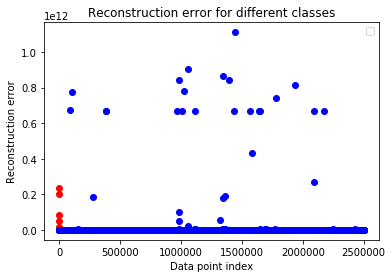

In [59]:
fig, ax = plt.subplots()

ax.plot(s_rt, marker='o', linestyle='', color='r')
ax.plot(s_nrt, marker='o', linestyle='', color='b')

ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

## Taking Ron's widened data

In [1]:
import networkx as nx
import pandas as pd
from sklearn.preprocessing import RobustScaler

In [2]:
df = pd.read_csv('../auth_filtered_all_with_labels_sorted_2_with_labels_filtered.csv')

cols = ["time","src_nt_host","dest_nt_host", "is_malicious"]

df = df[cols]

print("DF Shape: " + str(df.shape))

DF Shape: (10000704, 4)


In [3]:
df = df.sort_values(['src_nt_host', 'time'], ascending=[True, True])

df['secs_since_last_login_by_src_nt_host'] = df.groupby(['src_nt_host'], sort=False)['time'].diff()

df['secs_since_last_login_by_src_nt_host'].fillna(0, inplace=True)

In [4]:
""" Function to bin time to a given hour """
import math

bins = [ i for i in range(1,math.ceil(df['time'].max() / 3600) + 1)]


def bin_time(time):
    return bins[math.ceil(time / 3600) - 1]

In [5]:
#Let's bin time and convert the seconds to a given hr 
df['bin_timed'] = df['time'].apply(bin_time)

In [6]:
#Let's find the distinct number of dest hosts for a src_host in a given hour
df['num_distinct_dest_nt_host_per_src_nt_host_per_hour'] = \
    df.groupby(['bin_timed','src_nt_host'])['dest_nt_host'].transform('nunique')

In [7]:
scaler = RobustScaler()

In [8]:
df[['num_distinct_dest_nt_host_per_src_nt_host_per_hour','secs_since_last_login_by_src_nt_host']] = \
    scaler.fit_transform(df.as_matrix(['num_distinct_dest_nt_host_per_src_nt_host_per_hour','secs_since_last_login_by_src_nt_host']))

In [9]:
df = df[['src_nt_host','dest_nt_host','secs_since_last_login_by_src_nt_host', 'num_distinct_dest_nt_host_per_src_nt_host_per_hour']]

In [10]:
df.head(1)

,src_nt_host,dest_nt_host,secs_since_last_login_by_src_nt_host,num_distinct_dest_nt_host_per_src_nt_host_per_hour
1820919,C1,C529,0.0,-1.75


In [11]:
dummies = pd.get_dummies(df['dest_nt_host'])
df[dummies.columns] = dummies

In [1]:
df.head(1)[['src_nt_host', 'C529']]

NameError: name 'df' is not defined